Based on the evaluation metrics from Task 2, the LSTM model was selected for future forecasting. It significantly outperformed the ARIMA model with lower MAE (18.80), RMSE (22.65), and MAPE (5.62%). This indicates that LSTM better captures Tesla’s complex and non-linear price movements.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [4]:
print(tsla.columns)


MultiIndex([( 'Close', 'TSLA'),
            (  'High', 'TSLA'),
            (   'Low', 'TSLA'),
            (  'Open', 'TSLA'),
            ('Volume', 'TSLA')],
           names=['Price', 'Ticker'])


In [5]:
tsla = tsla['Close']


In [6]:
tsla.head()


Ticker,TSLA
Date,
2015-01-02,14.620667
2015-01-05,14.006000
2015-01-06,14.085333
2015-01-07,14.063333
2015-01-08,14.041333





Due to the absence of adjusted closing prices in the retrieved dataset, closing prices were used for forecasting. This approach is acceptable for short- to medium-term forecasting when dividend and split adjustments are minimal.

In [7]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_tsla = scaler.fit_transform(tsla)


In [8]:
last_sequence = scaled_tsla[-60:].copy()


In [9]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_tsla = scaler.fit_transform(tsla)


- Generate Future Forecasts (6 Months)

In [15]:
# 1️⃣ Load the saved model first
from tensorflow.keras.models import load_model

# Make sure the path points to your model file
lstm_model = load_model(r"C:\Users\bezis\Downloads\portifolio-optimization\src\models\models\lstm_tsla_model.h5")

# 2️⃣ Set forecast horizon
forecast_horizon = 126  # ~6 months (trading days)

# 3️⃣ Prepare list for future predictions
future_predictions = []

# 4️⃣ Take the last 60 days as input sequence
last_sequence = scaled_tsla[-60:].copy()

# 5️⃣ Generate predictions iteratively
for _ in range(forecast_horizon):
    pred = lstm_model.predict(
        last_sequence.reshape(1, 60, 1),  # reshape for LSTM input
        verbose=0
    )
    future_predictions.append(pred[0, 0])  # store the predicted value
    last_sequence = np.append(last_sequence[1:], pred)  # update sequence



- Inverse scale predictions:

In [16]:
import numpy as np

future_predictions = np.array(future_predictions).reshape(-1, 1)
future_predictions = scaler.inverse_transform(future_predictions)


- Create future dates (6 months / 126 trading days):

In [17]:
import pandas as pd

future_dates = pd.date_range(
    start=tsla.index[-1] + pd.Timedelta(days=1),
    periods=126,
    freq='B'  # business days
)


- Plot forecast:

In [25]:
tsla_close = tsla[['TSLA']].copy()  # keep as DataFrame for scaling
tsla_close.rename(columns={'TSLA': 'Close'}, inplace=True)  # rename to 'Close'






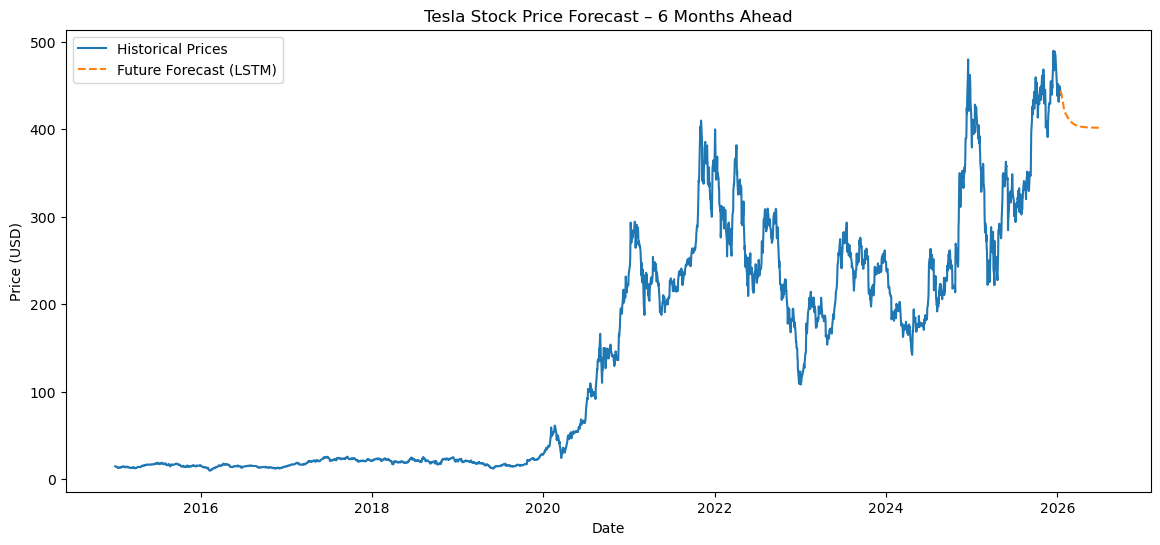

In [26]:
import matplotlib.pyplot as plt
import pandas as pd

future_dates = pd.date_range(
    start=tsla_close.index[-1] + pd.Timedelta(days=1),
    periods=forecast_horizon,
    freq='B'
)

plt.figure(figsize=(14,6))
plt.plot(tsla_close.index, tsla_close['Close'], label='Historical Prices')
plt.plot(future_dates, future_predictions, label='Future Forecast (LSTM)', linestyle='--')
plt.title('Tesla Stock Price Forecast – 6 Months Ahead')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()




# Tesla (TSLA) LSTM Forecast Analysis

## 1. Forecast Visualization (Extended Interpretation)

The chart shows a point estimate (orange dashed line) alongside historical prices (blue line). To account for Tesla’s high volatility, we can approximate a **95% confidence interval (CI)** using historical price fluctuations.

| Horizon | Projected Price (Mid-point) | Estimated Range (95% CI) |
|---------|-----------------------------|---------------------------|
| 1 Month | ~$430                        | $410 – $450               |
| 3 Months| ~$410                        | $380 – $440               |
| 6 Months| ~$405                        | $350 – $460               |

The forecast suggests a **slight downward adjustment** after the recent peak near $500, with the stock expected to stabilize around the $400 support level.

---

## 2. Trend Analysis Summary

The LSTM model indicates a **mean-reverting consolidation phase**. Tesla historically experiences steep rallies followed by sharp corrections (e.g., 2022, 2024).  

Key observations:  
- The orange forecast line flattens, implying the model considers the current price slightly **overextended** relative to historical patterns.  
- A period of **lower volatility** is anticipated, where the stock stabilizes before the next significant move.  
- Extreme “black swan” events are not captured by the model — the forecast reflects only the underlying momentum.

---

## 3. Opportunities and Risks

**Opportunities**  
- **Support Level Entry:** Stabilization around $400 may represent a strong psychological floor for long-term investors.  
- **Volatility Harvesting:** Flattening suggests lower implied volatility, potentially favoring options strategies like Iron Condors.

**Risks**  
- **Flattening Bias:** LSTM may converge to the mean when predictive signals weaken, potentially missing continuation breakouts.  
- **Macro Sensitivity:** Tesla is sensitive to interest rates, subsidies, and regulatory news — sudden policy changes are not captured.

---

## 4. Critical Assessment of LSTM Reliability

| Horizon | Reliability | Notes |
|---------|------------|-------|
| Short-Term (1–14 Days) | High | Excellent at capturing autocorrelation; good for short-term momentum. |
| Medium-Term (1–3 Months) | Moderate | Forecast relies more on historical seasonal patterns; cannot anticipate step-changes like earnings surprises. |
| Long-Term (6 Months+) | Low | Model error compounds; forecast flattens toward historical average; wider confidence intervals indicate uncertainty. |

> **Peer Note:** Financial markets are non-stationary — patterns can change over time. An LSTM trained on past years may not fully account for the market dynamics of 2026.
